In [1]:
import firedrake as fd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps
import seaborn as sns

import hydrogym as gym

mpl.rc("text", usetex=False)
mpl.rc("font", family="serif")
mpl.rc("xtick", labelsize=14)
mpl.rc("ytick", labelsize=14)
mpl.rc("axes", labelsize=20)
mpl.rc("axes", titlesize=20)
mpl.rc("figure", figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

fd.utils.ScalarType

dtype('float64')

/home/firedrake/firedrake/lib/python3.8/site-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


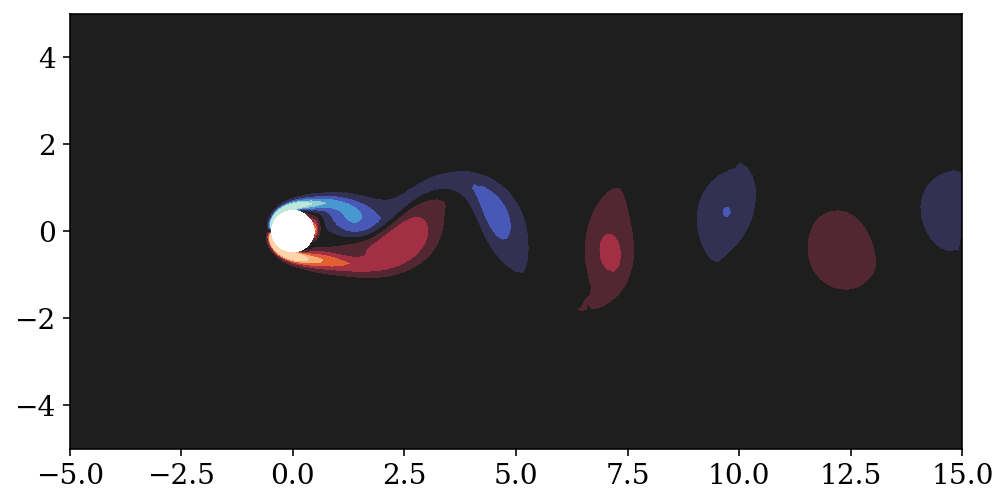

In [2]:
flow = gym.flow.Cylinder(Re=100, h5_file="../transient/checkpoint.h5")
# with fd.CheckpointFile('limit-cycle/pod.h5', 'r') as file:
#     psi = file.load_function(flow.mesh, 'q', idx=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-5, 5, 10)
fd.tricontourf(
    flow.vorticity(),
    axes=ax,
    levels=levels,
    extend="both",
    cmap=sns.color_palette("icefire", as_cmap=True),
)
plt.show()

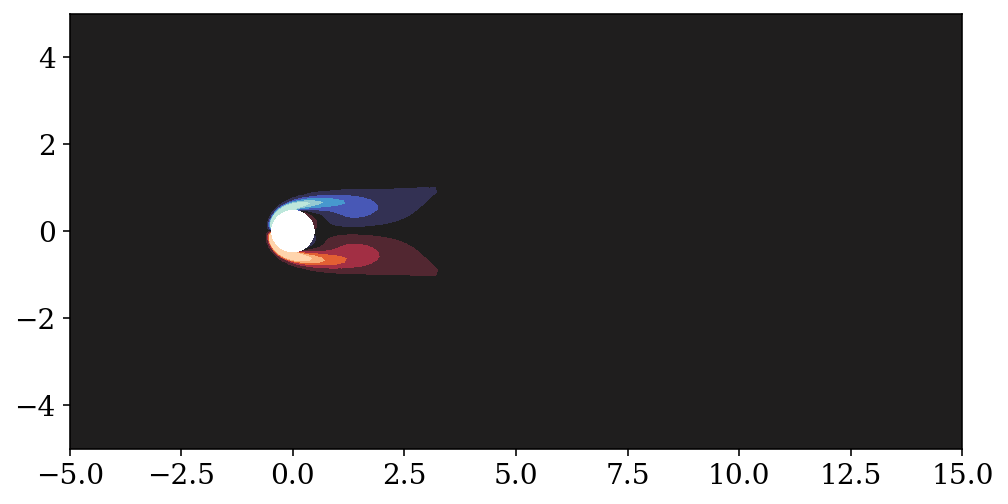

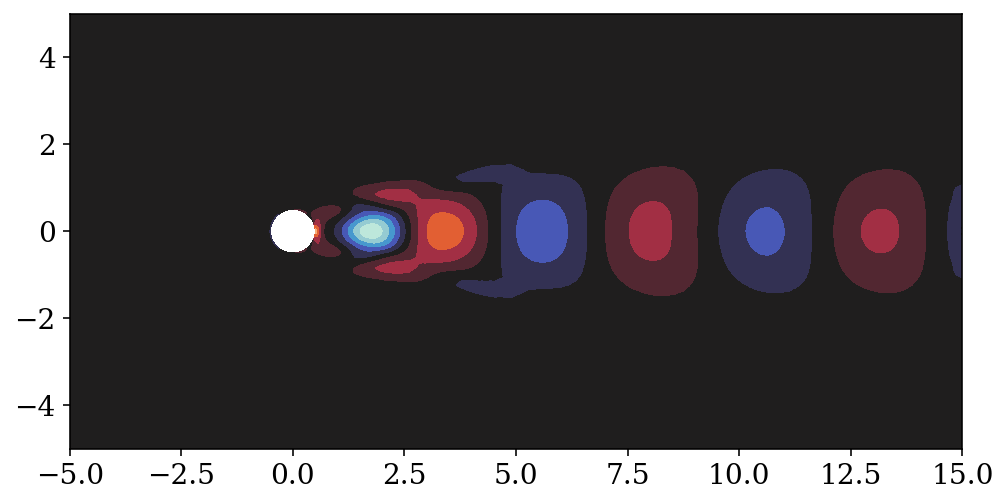

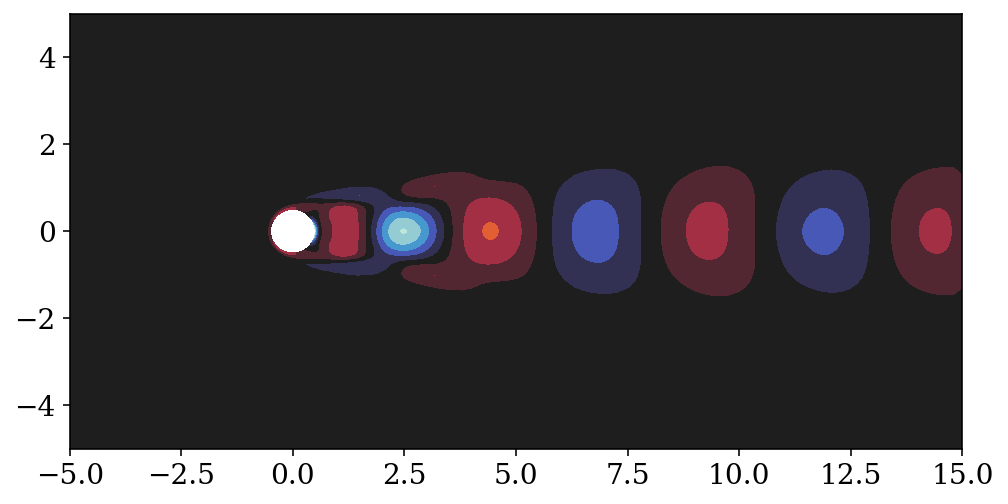

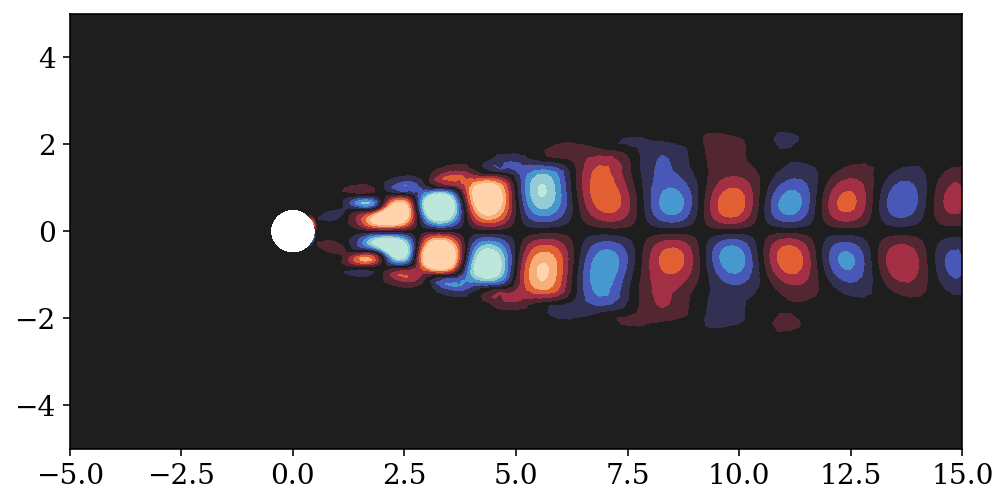

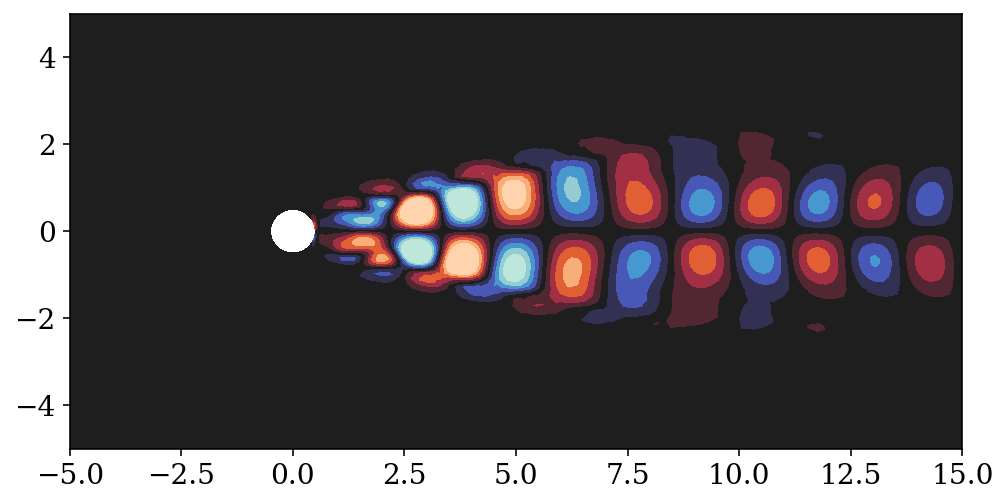

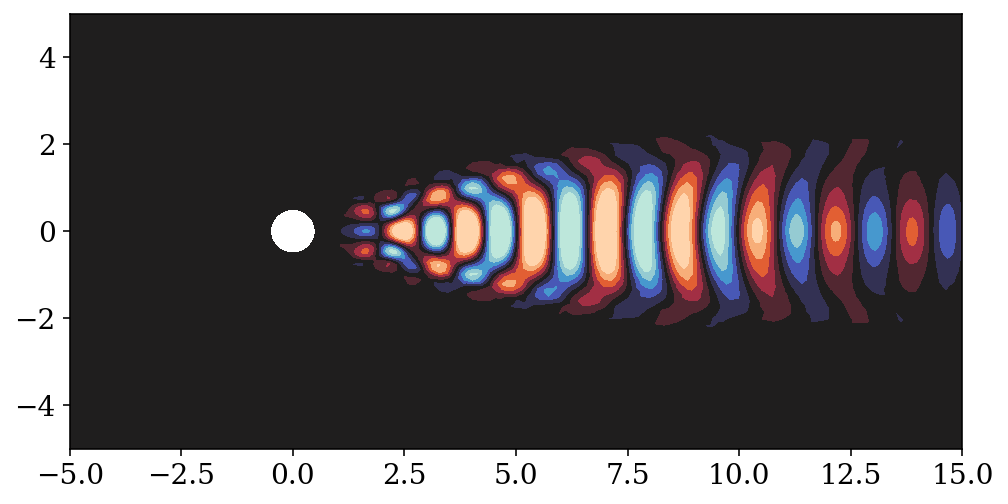

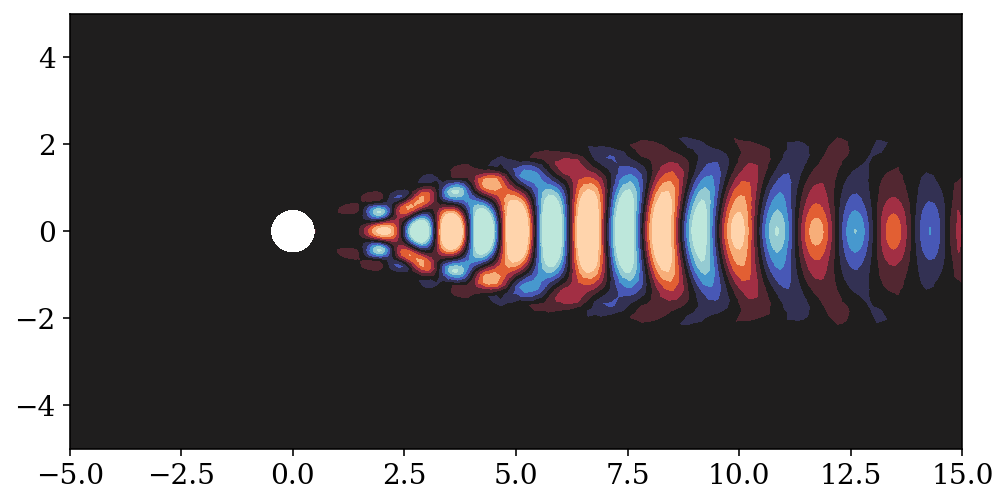

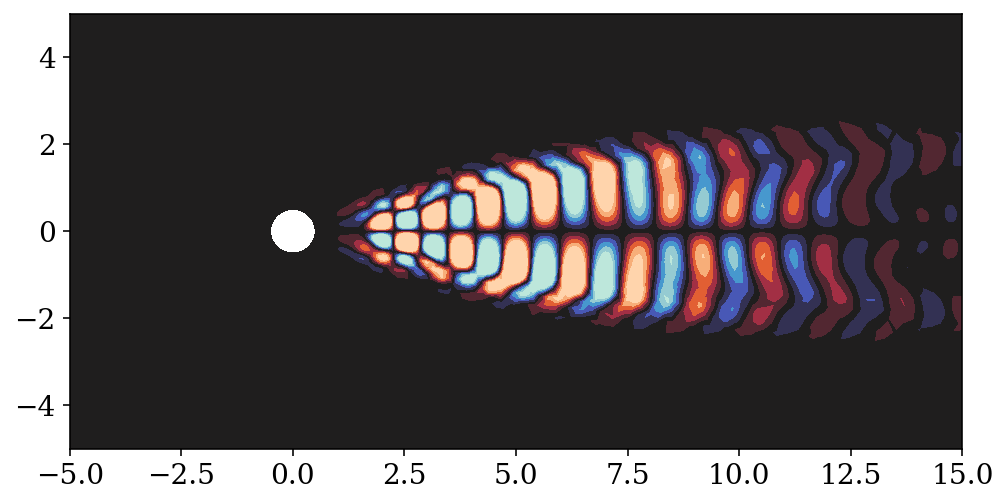

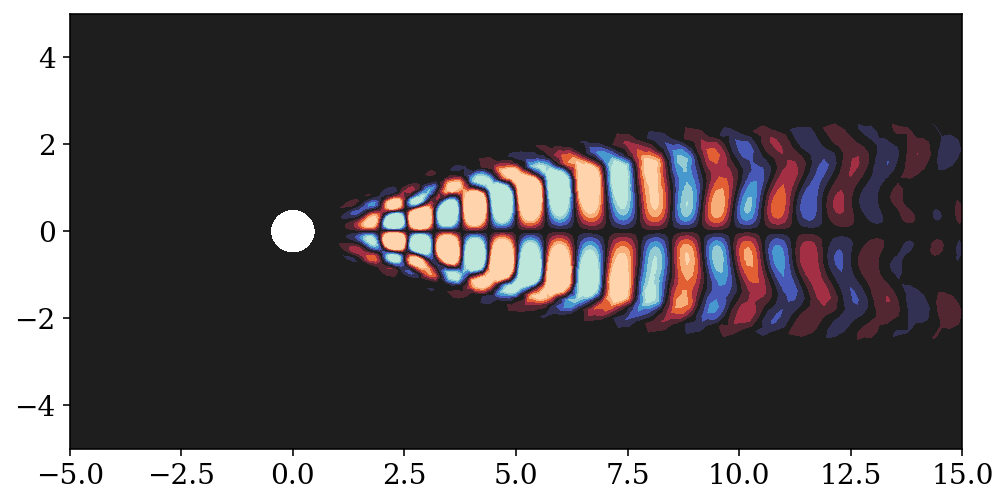

In [4]:
r = 8
mode_path = "../modred/output"
gym.utils.set_from_array(flow.q, np.load(f"{mode_path}/mean.npy"))

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
levels = np.linspace(-5, 5, 10)
fd.tricontourf(
    flow.vorticity(),
    axes=ax,
    levels=levels,
    extend="both",
    cmap=sns.color_palette("icefire", as_cmap=True),
)
plt.show()

psi = []
for i in range(r):
    gym.utils.set_from_array(flow.q, np.load(f"{mode_path}/pod{i}.npy"))
    psi.append(flow.q.copy(deepcopy=True))

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    levels = np.linspace(-1, 1, 10)
    fd.tricontourf(
        flow.vorticity(),
        axes=ax,
        levels=levels,
        extend="both",
        cmap=sns.color_palette("icefire", as_cmap=True),
    )
    plt.show()

In [5]:
for i in range(r):
    for j in range(r):
        print(i, j, flow.dot(psi[i], psi[j]))

0 0 1.000000000000004
0 1 5.577745838987458e-16
0 2 -1.9882912590668544e-16
0 3 -1.6940658945086007e-16
0 4 1.973434301172014e-16
0 5 5.996586690745764e-16
0 6 3.0019355870460757e-16
0 7 7.508184747756844e-17
1 0 5.577745838987458e-16
1 1 1.0000000000000002
1 2 -1.6822413145649306e-16
1 3 -2.997276905836177e-16
1 4 3.3556734864784166e-16
1 5 -5.948983439110073e-16
1 6 9.460858271391655e-16
1 7 2.0681452901692536e-16
2 0 -1.9882912590668544e-16
2 1 -1.6822413145649306e-16
2 2 0.999999999999996
2 3 -3.766247296671521e-17
2 4 3.0624438091496602e-15
2 5 -1.3830082912225095e-15
2 6 -3.062675896177208e-15
2 7 3.870171463036046e-15
3 0 -1.6940658945086007e-16
3 1 -2.997276905836177e-16
3 2 -3.766247296671521e-17
3 3 0.999999999999993
3 4 7.184533458610975e-18
3 5 1.2910814995228947e-16
3 6 -2.4224464665115186e-16
3 7 6.143699373024891e-16
4 0 1.973434301172014e-16
4 1 3.3556734864784166e-16
4 2 3.0624438091496602e-15
4 3 7.184533458610975e-18
4 4 0.9999999999999987
4 5 2.059397133890011e-15
4

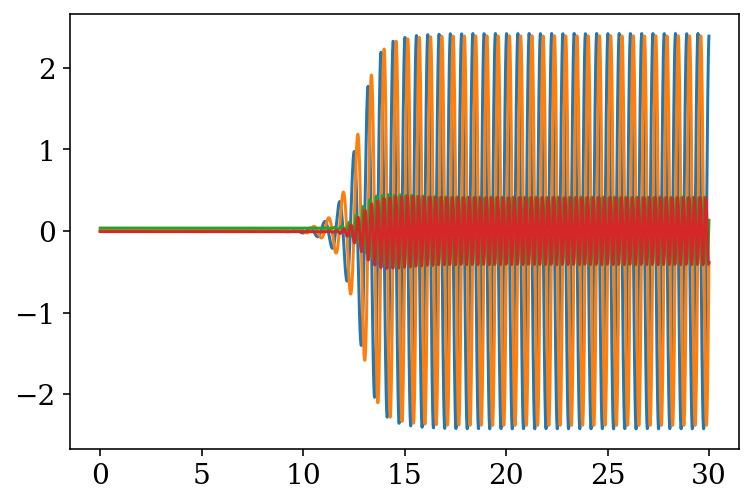

In [7]:
data = np.loadtxt("../modred/output/coeffs.dat")
dt = 1e-2
a = data.T
t = dt * np.arange(a.shape[0])

plt.plot(t, a[:, 0])
plt.plot(t, a[:, 1])
plt.plot(t, a[:, 2])
plt.plot(t, a[:, 3])

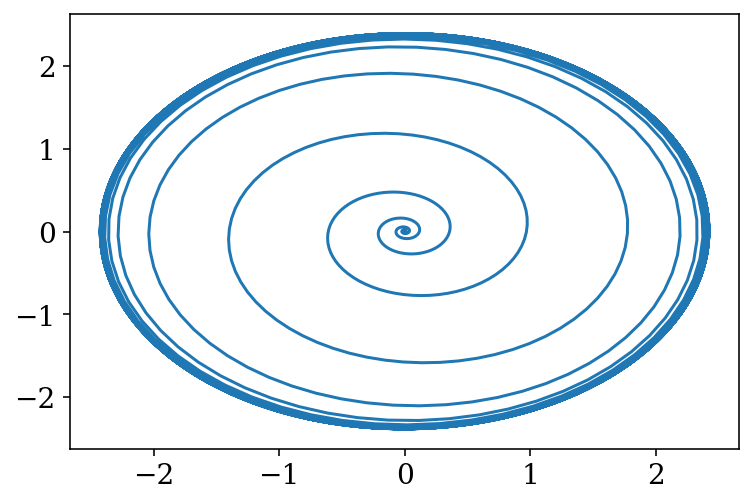

In [8]:
plt.plot(a[:, 0], a[:, 1])

# Fit SINDy model to the natural dynamics

In [9]:
data = np.loadtxt("../transient/output/force.dat")
t, L, D = data.T

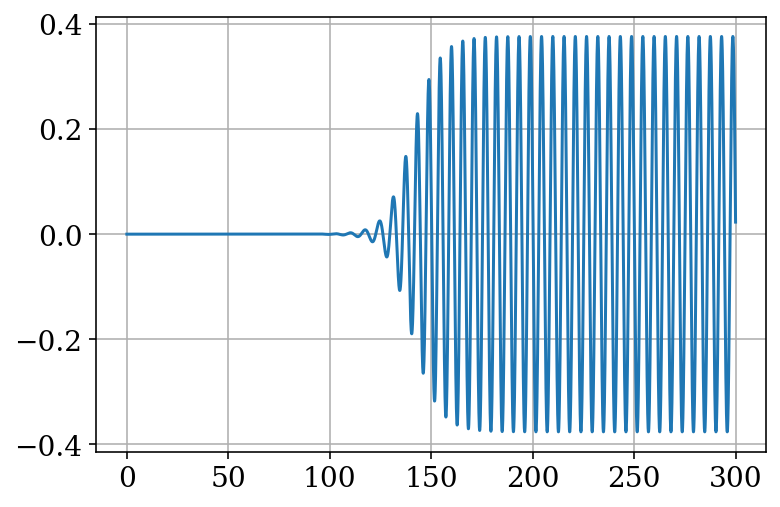

In [10]:
plt.plot(t, L)
plt.grid()

In [11]:
dt = t[1] - t[0]


def fd_deriv(x, dt=dt):
    dx = np.zeros_like(x)
    dx[1:-1] = (x[2:] - x[:-2]) / (2 * dt)
    dx[0] = (x[1] - x[0]) / dt
    dx[-1] = (x[-1] - x[-2]) / dt
    return dx

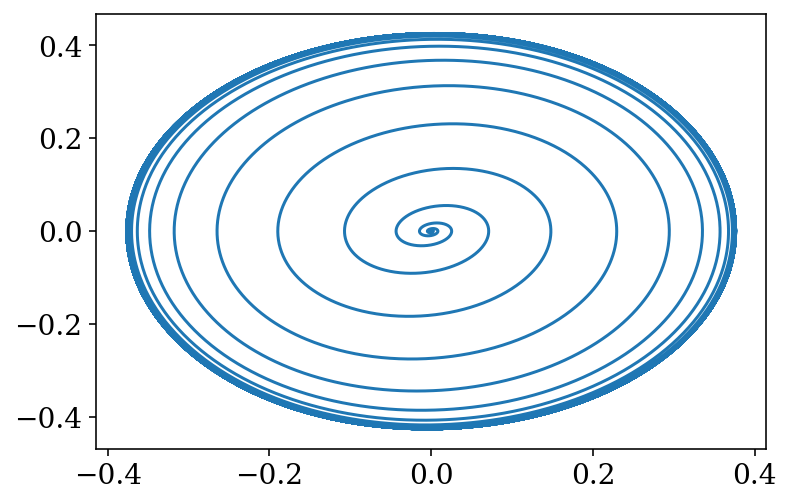

In [12]:
dL = fd_deriv(L)
plt.plot(L, dL)

In [13]:
x_train = np.vstack([L, dL]).T

# Instantiate and fit the SINDy model
lib = ps.PolynomialLibrary(degree=3)

# opt = ps.SR3(threshold=0.1, thresholder='l0')
opt = ps.STLSQ(threshold=1e-2)
model = ps.SINDy(feature_library=lib, optimizer=opt)
model.fit(x_train, t=dt)
model.print()

(x0)' = 1.000 x1
(x1)' = -1.149 x0 + 0.205 x1 + -0.994 x0^3 + -1.769 x0^2 x1 + -0.656 x0 x1^2 + -1.052 x1^3


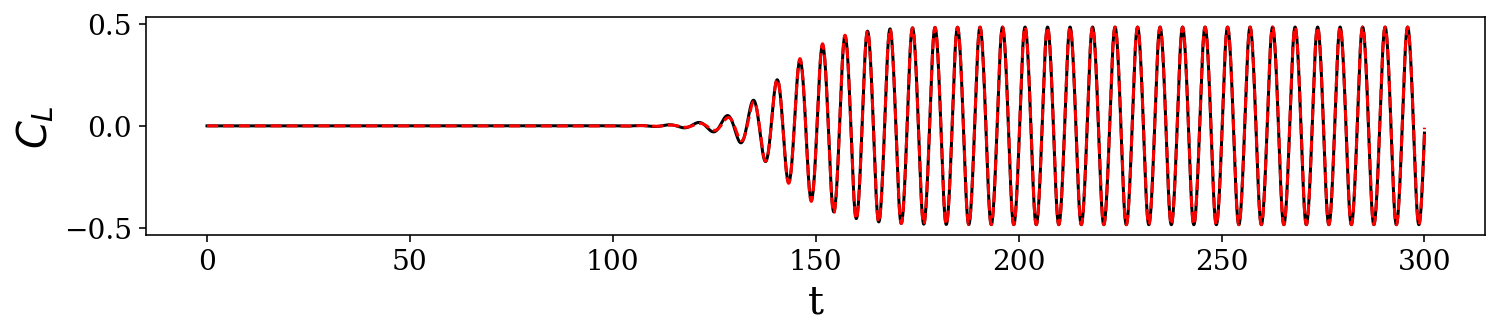

In [14]:
t_test = t
x_test = x_train
x0_test = x_test[0, :]

dx_pred = model.predict(x_test)
dx_fd = model.differentiate(x_test, t=dt)

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
ax.plot(t_test, dx_pred[:, 1], "k", label="model prediction")
ax.plot(t_test, dx_fd[:, 1], "r--", label="finite difference")
ax.set(xlabel="t", ylabel="$C_L$")

fig.show()

In [15]:
x0_test

array([3.91016880e-05, 4.74104422e-08])

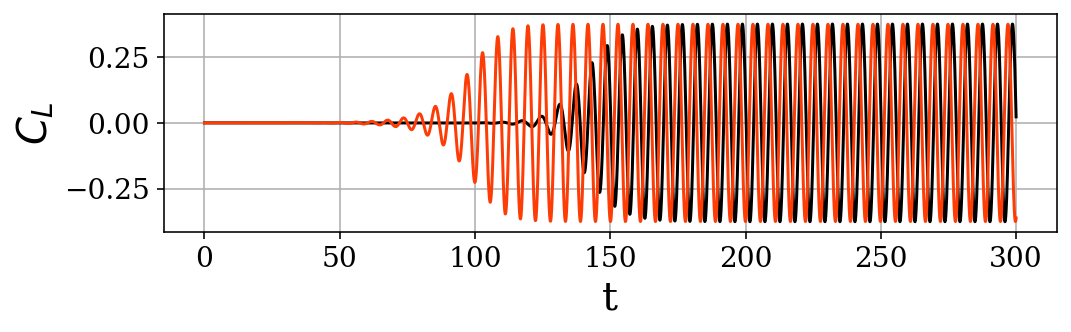

In [16]:
t_test = t
x_test = x_train
x0_test = np.array([-1e-5, 0.0])
x_test_sim = model.simulate(x0_test, t_test)

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(t_test, x_test[:, 0], "k", label="DNS")
ax.plot(t_test, x_test_sim[:, 0], c="xkcd:red orange", label="SINDy")
ax.set(xlabel="t", ylabel="$C_L$")

ax.grid()
fig.show()

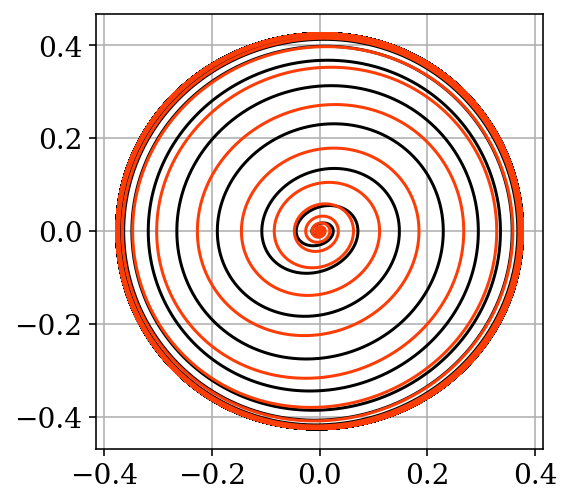

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(x_test[:, 0], x_test[:, 1], c="k", label="DNS")
ax.plot(x_test_sim[:, 0], x_test_sim[:, 1], c="xkcd:red orange", label="SINDy")

ax.grid()
fig.show()